In [1]:
import mtcnn
import pandas as pd
import numpy as np
from numpy import asarray
from PIL import Image
from mtcnn.mtcnn import MTCNN
from os import listdir
from os.path import isdir
from matplotlib import pyplot
from numpy import expand_dims
from keras.models import load_model
from keras_facenet import FaceNet
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [2]:
# Extracting the face in the image
def extract_human_face(filename, size_needed=(160,160)):
    # load image from file
    image = Image.open(filename)
    # convert image to RGB, if needed
    image = image.convert('RGB')
    # convert to array
    pixels = asarray(image)
    # create the detector, using default weights
    detector = MTCNN()
    # detect faces in the image
    results = detector.detect_faces(pixels)
    # extract the bounding box from the first face
    x1, y1, width, height = results[0]['box']

    x1, y1 =  abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height

    # extract the face using the coordinates
    face = pixels[y1:y2, x1:x2]

    # resize pizels to the model size
    image = Image.fromarray(face)
    image = image.resize(size_needed) # or  Image.resize((160,160))  # naturally, I prefer 224 x 224 but oh well
    face_array = asarray(image)
    
    return face_array

In [3]:
folder = '/Users/Kenechi/Artifical Intelligence/Project Vindler/FaceRecognition-Vindler/face_data/whoisthis/'

In [4]:
name_file = pd.read_csv('/Users/Kenechi/Artifical Intelligence/Project Vindler/FaceRecognition-Vindler/face_data/name_tags.csv')

In [5]:
name_file.head()

,image_name,tags
0,train_1,Beyonce
1,train_2,Beyonce
2,train_3,Beyonce
3,train_4,Beyonce
4,train_5,Beyonce


In [6]:
# Tagging the tags to the names
def names(name_file):
    name_tag= dict()
    for i in range(len(name_file)):
        name, tags = name_file["image_name"][i], name_file['tags'][i]
        name_tag[name] = tags
    return(name_tag)


In [7]:
see = names(name_file)

In [8]:
#see

In [9]:
# Creating the dataset

def create_dataset(directory, name_file):
    
    name_targ = names(name_file)
    x, y = list(), list()
    faces = list()
    targets = []
    
    for sub in listdir(directory):
        if sub != 'Thumbs.db':
            #print(sub)
            path = directory + sub #+ '/'
            
            #print(path)

            # load faces
            face = extract_human_face(path)
            
            faces.append(face)

            # load targets
            targets.append(name_targ[sub.split('.')[0]])

            x.extend(faces)
            y.extend(targets)

    return asarray(x), asarray(y)
        
        

In [10]:
# obtaining the data for x and y
train_data_x, train_data_y = create_dataset(folder, name_file)

In [11]:
print(train_data_x.shape)
print(train_data_y.shape)

(11325, 160, 160, 3)
(11325,)


In [12]:
train_x = train_data_x[:11000]
train_y = train_data_y[:11000]

In [13]:
test_x = train_data_x[11000:]
test_y = train_data_y[11000:]

In [14]:
print(f'Train shape for the features {train_x.shape}')
print(f'Train shape for the Targets {train_y.shape}')
print(f'Test shape for the features {test_x.shape}')
print(f'Test shape for the Targets {test_y.shape}')

Train shape for the features (11000, 160, 160, 3)
Train shape for the Targets (11000,)
Test shape for the features (325, 160, 160, 3)
Test shape for the Targets (325,)


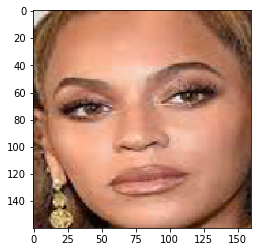

In [15]:
pyplot.imshow(train_x[0])

In [16]:
train_y[0]

'Beyonce'

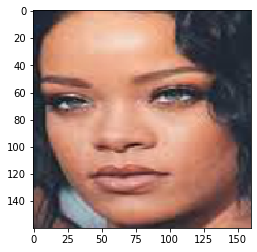

In [17]:
pyplot.imshow(test_x[0])

In [18]:
test_y[0]

'Rihanna'

In [19]:
# obtaining the facenet model
embedder = FaceNet()

# load the pre-trained facenet model
model = load_model('facenet_keras.h5')

In [20]:
# generating the embeddings
def get_embedding(face_pixels):
    # scale pixel values
    #print('Creating Embeddings ... ')
    face_pixels = face_pixels.astype('float32')
    #print(f'face images after float32{face_pixels.shape}')
    # standardize pixel values across channels (global)
    mean,std =face_pixels.mean(), face_pixels.std()
    face_pixels = (face_pixels - mean) / std
    
    # transform face into one sample
    samples = expand_dims(face_pixels, axis=0)
    #print(f'samples after expand_dims{samples.shape}')
    
    
    # make prediction to get embedding
    #embedding = embedder.embeddings(samples)
    #print(f'embeddings {embedding.shape}')
    
    y_embed = model.predict(samples)
    # get embedding
    embedding = y_embed[0]
    
   
    return embedding

In [21]:
embedded_train_x = []
embedded_test_x = []

In [22]:
# storing the embeddings for training 
for face_pixels in train_x:
    embedding = get_embedding(face_pixels)
    embedded_train_x.append(embedding)

In [23]:
# storing the embeddings for testing
for face_pixels in test_x:
    embedding = get_embedding(face_pixels)
    embedded_test_x.append(embedding)

In [24]:
assert len(embedded_train_x) == len(train_y)
assert len(embedded_test_x) == len(test_y)

### For Training

In [25]:
# converting to array
embedded_train_x =  asarray(embedded_train_x)

In [26]:
embedded_train_x.shape

(11000, 128)

In [27]:
# reshaping the data
embedded_train_x = embedded_train_x.reshape((11000, 1*128))

In [28]:
embedded_train_x.shape

(11000, 128)

In [29]:
train_y.shape

(11000,)

In [30]:
# normalize the data
norm = Normalizer(norm='l2') # using the ridge regularizer
embedded_train_x = norm.transform(embedded_train_x)

In [31]:
assert len(embedded_train_x) == len(train_y)

### For testing

In [32]:
# converting to array
embedded_test_x =  asarray(embedded_test_x)

In [33]:
embedded_test_x.shape

(325, 128)

In [34]:
# reshaping the data
embedded_test_x = embedded_test_x.reshape((325, 1*128))

In [35]:
embedded_test_x.shape

(325, 128)

In [36]:
test_y.shape

(325,)

In [37]:
# normalize the data
embedded_test_x= norm.transform(embedded_test_x)

In [38]:
assert len(embedded_test_x) == len(test_y)

### Model performance

In [39]:
# split the data
from sklearn.model_selection import train_test_split
x_train, x_test, y_train,y_test = train_test_split(embedded_train_x, train_y , test_size = 0.2, random_state = 3)

In [40]:
# creating the svm model
#Facemodel = SVC(kernel='linear', probability=True)
#Facemodel.fit(x_train, y_train)

# ---------------------------------------------------------------------------------------------------------------------------

Facemodel = SGDClassifier(loss="log", penalty="l2")
Facemodel.partial_fit(x_train, y_train, classes= np.unique(y_train))


SGDClassifier(loss='log')

In [41]:
x_test.shape

(2200, 128)

In [42]:
# Predictions
y_pred = Facemodel.predict(x_test)

In [43]:
y_pred[:5]

array(['The Weeknd', 'Meg The Stallion', 'Drake', 'Drake', 'Beyonce'],
      dtype='<U16')

In [44]:
y_test[:5]

array(['The Weeknd', 'Meg The Stallion', 'Drake', 'Drake', 'Beyonce'],
      dtype='<U16')

### Model Evaluation

In [45]:
cn = confusion_matrix(y_test, y_pred)

In [46]:
print(cn)

[[269   0   0   0   0]
 [  0 638   0   0   0]
 [  0   0 517   0   0]
 [  0   0   0 284   0]
 [  0   0   0   0 492]]


In [47]:
print(classification_report(y_test, y_pred))

                  precision    recall  f1-score   support

         Beyonce       1.00      1.00      1.00       269
           Drake       1.00      1.00      1.00       638
Meg The Stallion       1.00      1.00      1.00       517
         Rihanna       1.00      1.00      1.00       284
      The Weeknd       1.00      1.00      1.00       492

        accuracy                           1.00      2200
       macro avg       1.00      1.00      1.00      2200
    weighted avg       1.00      1.00      1.00      2200



In [48]:
print(accuracy_score(y_pred, y_test) * 100)

100.0


### Lets see how it performs on embedded x test

In [49]:
x_train, x_test, y_train,y_test = train_test_split(embedded_test_x, test_y , test_size = 0.1, random_state = 3)

### For train features

In [50]:
y_pred1 = Facemodel.predict(x_train)

In [51]:
cn = confusion_matrix(y_train, y_pred1)
print(cn)

[[55  0  0  0  0]
 [ 0 55  0  0  0]
 [ 0  0 55  0  0]
 [ 0  0  0 65  0]
 [ 0  0  0  0 62]]


In [52]:
print(classification_report(y_train, y_pred1))

                  precision    recall  f1-score   support

         Beyonce       1.00      1.00      1.00        55
           Drake       1.00      1.00      1.00        55
Meg The Stallion       1.00      1.00      1.00        55
         Rihanna       1.00      1.00      1.00        65
      The Weeknd       1.00      1.00      1.00        62

        accuracy                           1.00       292
       macro avg       1.00      1.00      1.00       292
    weighted avg       1.00      1.00      1.00       292



In [53]:
print(accuracy_score(y_pred1, y_train) * 100)

100.0


In [54]:
y_pred1[:5]

array(['Rihanna', 'Meg The Stallion', 'Drake', 'Meg The Stallion',
       'Drake'], dtype='<U16')

In [55]:
y_train[:5]

array(['Rihanna', 'Meg The Stallion', 'Drake', 'Meg The Stallion',
       'Drake'], dtype='<U16')

### For Test features

In [56]:
y_pred2 = Facemodel.predict(x_test)

In [57]:
cn = confusion_matrix(y_test, y_pred2)
print(cn)

[[ 7  0  0  0  0]
 [ 0  5  0  0  0]
 [ 0  0  5  0  0]
 [ 0  0  0 12  0]
 [ 0  0  0  0  4]]


In [58]:
print(classification_report(y_test, y_pred2))

                  precision    recall  f1-score   support

         Beyonce       1.00      1.00      1.00         7
           Drake       1.00      1.00      1.00         5
Meg The Stallion       1.00      1.00      1.00         5
         Rihanna       1.00      1.00      1.00        12
      The Weeknd       1.00      1.00      1.00         4

        accuracy                           1.00        33
       macro avg       1.00      1.00      1.00        33
    weighted avg       1.00      1.00      1.00        33



In [59]:
print(accuracy_score(y_pred2, y_test) * 100)

100.0


In [60]:
y_pred2[:5]

array(['Drake', 'Rihanna', 'The Weeknd', 'Drake', 'Drake'], dtype='<U16')

In [61]:
y_test[:5]

array(['Drake', 'Rihanna', 'The Weeknd', 'Drake', 'Drake'], dtype='<U16')

### Checking random Images

In [62]:
import random

In [75]:
#  pick a random image
def check_random_image2(x,n):
    
    face = x[random.randint(0, n)] 
    
    face_embedding = get_embedding(face)

    #face_embedding = embedder.embeddings(sample)
    #face_embedding =  model.predict(sample)
    #face_embedding = face_embedding[0]
    face_embedding = asarray(face_embedding)
    face_embedding = face_embedding.reshape((1, 1*128))
    face_embedding  = norm.transform(face_embedding)
    y_predict = Facemodel.predict(face_embedding)
    y_prob2 = Facemodel.predict_proba(face_embedding)
    pyplot.imshow(face)
    title = '%s (%.3f)' % (y_predict[0], y_prob2[0][0] * 100)
    pyplot.title(title)
    pyplot.show()

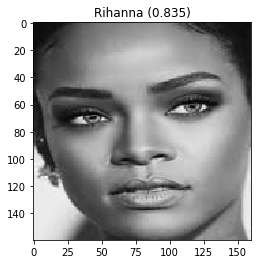

In [92]:
check_random_image2(test_x,len(test_x))

In [87]:
# Note: faces return very low prediction probability, beyonces face has the highest prediction probabilty of >80%

In [ ]:
# Why is beyonce face returning very high probablity? 

In [ ]:
# Conclusion:
# WE NEED MORE DATA, 30 PER FACE IS NOT ENOUGH FOR THE FACENET MODEL BUT IS PERFECTLY FINE FOR THE PRE-TRAINED MODEL

In [ ]:
# TEXT REFERENCES:

# https://ai.stackexchange.com/questions/4864/what-is-the-concept-of-tensorflow-bottlenecks#:~:text=In%20a%20CNN%20(such%20as,output%20channels%20than%20input%20channels.
# https://stats.stackexchange.com/questions/262044/what-does-a-bottleneck-layer-mean-in-neural-networks
# https://machinelearningmastery.com/introduction-to-1x1-convolutions-to-reduce-the-complexity-of-convolutional-neural-networks/
# https://machinelearningmastery.com/convolutional-layers-for-deep-learning-neural-networks/
# https://www.machinelearningplus.com/nlp/cosine-similarity/
# http://faculty.juniata.edu/rhodes/ml/simdissim.htm
# https://medium.com/analytics-vidhya/triplet-loss-b9da35be21b8
# https://mathworld.wolfram.com/Hypersphere.html
# https://stats.stackexchange.com/questions/63558/difference-between-standard-and-spherical-k-means-algorithms/63650#:~:text=In%20each%20step%2C%20k%2Dmeans,distance%20measure%20is%20cosine%20dissimilarity.
# https://towardsdatascience.com/stochastic-gradient-descent-clearly-explained-53d239905d31
# https://medium.com/konvergen/an-introduction-to-adagrad-f130ae871827
# https://towardsdatascience.com/breaking-down-the-agglomerative-clustering-process-1c367f74c7c2

# CODE REFERENCES:

# https://machinelearningmastery.com/how-to-develop-a-face-recognition-system-using-facenet-in-keras-and-an-svm-classifier/
# https://medium.com/clique-org/how-to-create-a-face-recognition-model-using-facenet-keras-fd65c0b092f1
# https://sefiks.com/2018/09/03/face-recognition-with-facenet-in-keras/
# https://pypi.org/project/keras-facenet/